In [112]:
import pandas as pd

Load the welding dataset to analyze and predict the yield strength of the material.

In [113]:

df = pd.read_csv('../../welddb/welddb_cleaned_for_pca.csv')

### Handle Missing Values for Yield Strength Target

Handle missing values for the target variable 'Yield strength (MPa)' using iterative imputation with Bayesian Ridge estimator

In [114]:
# drop all other target columns

df = df.drop(columns=['Ultimate tensile strength (MPa)', 'Elongation (%)',
       'Reduction of Area (%)', 'Charpy temperature (deg C)',
       'Charpy impact toughness (J)', 'Hardness (kgmm-2)', '50 % FATT',
       'Primary ferrite in microstructure (%)',
       'Ferrite with second phase (%)', 'Acicular ferrite (%)',
       'Martensite (%)', 'Ferrite with carbide aggregate (%)','Puissance (W)'])


 These columns are either irrelevant for predicting yield strength or represent different target variables.

In [115]:
# Filter the dataset to include only rows where 'Yield strength (MPa)' is not missing
df_yield_strength = df[df['Yield strength (MPa)'].notna()]

# Check the shape of the dataset after filtering
df_yield_strength.shape

(780, 39)

### Visualize Missing Values

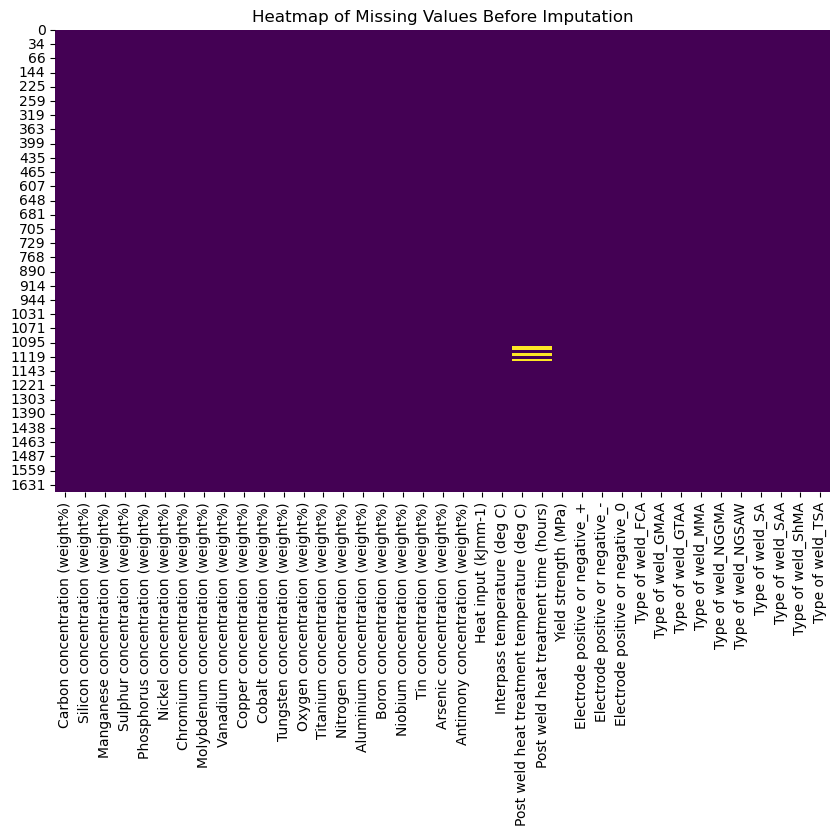

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.heatmap(df_yield_strength.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values Before Imputation')
plt.show()


In [116]:
# Count the number of missing values in each column before the imputation
missing_values_before_imputation = df_yield_strength.isnull().sum()
missing_values_before_imputation = missing_values_before_imputation[missing_values_before_imputation > 0]

# Display the columns that had missing values and their counts
missing_values_before_imputation

Post weld heat treatment temperature (deg C)    13
Post weld heat treatment time (hours)           13
dtype: int64

### Impute Missing Values Using Iterative Imputer with Bayesian Ridge

In [117]:
from sklearn.experimental import enable_iterative_imputer  # Required for Iterative Imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge  # Importer BayesianRidge

# Initialize the Iterative Imputer
iterative_imputer = IterativeImputer(estimator=BayesianRidge(), n_nearest_features=None,
                           imputation_order='ascending', random_state=42)
# Apply the iterative imputer on the dataset (excluding the target 'Yield strength (MPa)')
df_features = df_yield_strength.drop(columns=['Yield strength (MPa)'])
df_imputed_iterative = pd.DataFrame(iterative_imputer.fit_transform(df_features), columns=df_features.columns)

# Add back the target 'Yield strength (MPa)'
df_imputed_iterative['Yield strength (MPa)'] = df_yield_strength['Yield strength (MPa)'].values

# Display the first few rows of the imputed dataset
df_imputed_iterative.head()


,Carbon concentration (weight%),Silicon concentration (weight%),Manganese concentration (weight%),Sulphur concentration (weight%),Phosphorus concentration (weight%),Nickel concentration (weight%),Chromium concentration (weight%),Molybdenum concentration (weight%),Vanadium concentration (weight%),Copper concentration (weight%),...,Type of weld_GMAA,Type of weld_GTAA,Type of weld_MMA,Type of weld_NGGMA,Type of weld_NGSAW,Type of weld_SA,Type of weld_SAA,Type of weld_ShMA,Type of weld_TSA,Yield strength (MPa)
0,-1.612394,-0.254200,-1.447095,-0.136415,-0.048693,-0.318155,-0.427452,-0.56357,-0.146903,-0.289924,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,392.0
1,-1.612394,-0.254200,-1.447095,-0.136415,-0.048693,-0.318155,-0.427452,-0.56357,-0.146903,-0.289924,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,370.0
2,-1.612394,-0.165249,-0.452386,-0.225627,0.053550,-0.318155,-0.427452,-0.56357,-0.146903,-0.289924,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,413.0
3,-1.612394,-0.165249,-0.452386,-0.225627,0.053550,-0.318155,-0.427452,-0.56357,-0.146903,-0.289924,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,402.0
4,-1.319395,0.190556,0.594677,-0.225627,0.053550,-0.318155,-0.427452,-0.56357,-0.146903,-0.289924,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,468.0


### Train XGBoost Model

In [118]:
df1 = df_imputed_iterative.copy()

In [119]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer,root_mean_squared_error
from xgboost import XGBRegressor, plot_importance


In [120]:
# Separate features and target
X = df1.drop(columns=['Yield strength (MPa)'])
y = df1['Yield strength (MPa)']
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [121]:
def evaluate_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return mse, rmse, mae, r2

Initialize the XGBoost model with appropriate hyperparameters:

In [127]:
model = XGBRegressor(
    random_state=42,
    reg_lambda=1,   # L2 regularization term (lambda)
    reg_alpha=1,    # L1 regularization term (alpha)
    learning_rate=0.05,   # Lower learning rate for better generalization
    n_estimators=500,     # The maximum number of estimators
    max_depth=5,          # Moderate max depth to avoid overfitting
    eval_metric="rmse",   # Set the evaluation metric here in the constructor
)

Hyperparameter Tuning with Grid Search

In [123]:

scoring = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'RMSE': make_scorer(root_mean_squared_error, greater_is_better=False),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'R2': 'r2'
}

In [124]:
# Hyperparameter tuning
xgb_params = {
    'reg_lambda': [0.01, 0.1, 1, 10],
    'reg_alpha': [0.01, 0.1, 1, 10],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}

In [129]:
results = {
    'Model': [],
    'Best Parameters': [],
    'Test MSE': [],   
    'Test RMSE': [],  
    'Test MAE': [],   
    'Test R²': []
}

In [130]:

grid_search = GridSearchCV(estimator=model, param_grid=xgb_params, 
                           cv=5, scoring=scoring, refit='R2', return_train_score=True)
grid_search.fit(X_train, y_train)
# Best parameters and predictions
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

# Enregistrer les paramètres optimaux



test_mse, test_rmse, test_mae, test_r2 = evaluate_metrics(y_test, y_pred)
results['Model'].append(best_model)  # Append the model
results['Best Parameters'].append(best_params)  # Append best parameters
results['Test MSE'].append(test_mse)  # Append MSE
results['Test RMSE'].append(test_rmse)  # Append RMSE
results['Test MAE'].append(test_mae)  # Append MAE
results['Test R²'].append(test_r2)  # Append R²
# Convertir les résultats en DataFrame



results_df = pd.DataFrame(results)

# Afficher le DataFrame des résultats
results_df

Length of Model: 1
Length of Best Parameters: 1
Length of Test MSE: 1
Length of Test RMSE: 1
Length of Test MAE: 1
Length of Test R²: 1


,Model,Best Parameters,Test MSE,Test RMSE,Test MAE,Test R²
0,"XGBRegressor(base_score=None, booster=None, ca...","{'learning_rate': 0.1, 'max_depth': 3, 'reg_al...",1240.995723,35.227769,24.972698,0.862677


In [135]:
print(best_params)

{'learning_rate': 0.1, 'max_depth': 3, 'reg_alpha': 1, 'reg_lambda': 10}


Test R² (Coefficient of Determination): 0.86 indicates that 86% of the variance in yield strength is explained by the model, suggesting good model performance.

**Hyperparameters tuning**

Best Hyperparameters:

    -  learning_rate: 0.1

    - max_depth: 3

    - reg alpha: 1

    - reg lambda : 10


These settings show a balanced model that avoids overfitting while capturing the complexity of the data.

Ces paramètres indiquent que le modèle est relativement prudent (learning_rate de 0.1) et qu’il utilise une profondeur modérée pour les arbres, ce qui est probablement un compromis pour éviter le surapprentissage tout en capturant suffisamment de complexité.

- La combinaison de max_depth (3) et de reg_lambda élevé (10) suggère que le modèle favorise une approche prudente avec une forte régularisation. Cela a aidé à éviter le surapprentissage, ce qui est confirmé par le score R² de 0.86 et le test RMSE de 35.23.
- La régularisation L1 (reg_alpha = 1) permet une forme de sélection de caractéristiques automatique, limitant la complexité des arbres en pénalisant les arbres trop denses et contribuant à rendre le modèle plus généralisable.

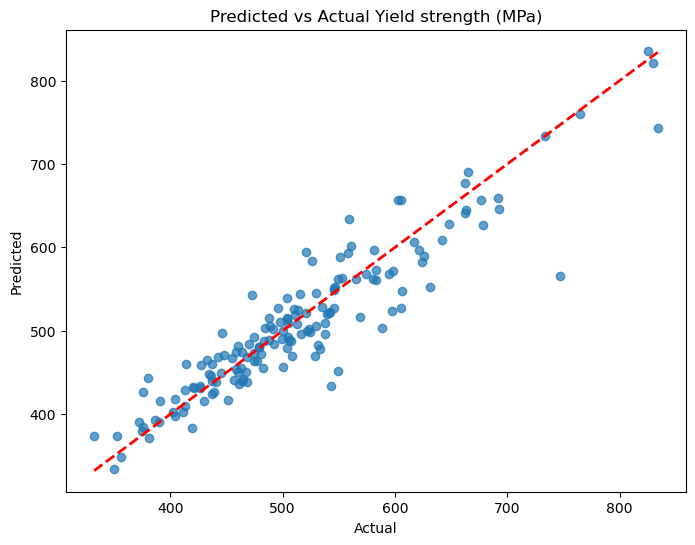

In [131]:
# Plot the predicted vs actual values
target_variable = 'Yield strength (MPa)'

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Predicted vs Actual {target_variable}')
plt.show()


The points are closely aligned with the ideal line, indicating accurate predictions.

<Figure size 1000x800 with 0 Axes>

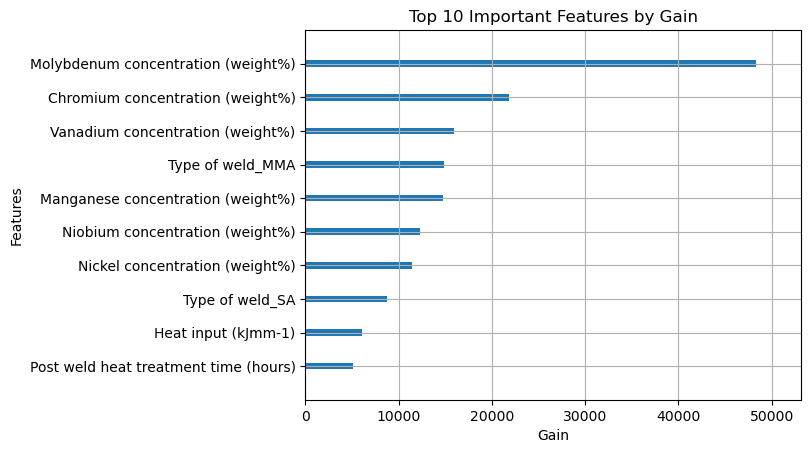

In [132]:
# Plot the feature importance with feature names
plt.figure(figsize=(10, 8))
plot_importance(best_model, importance_type='gain', max_num_features=10, show_values=False, xlabel="Gain")
plt.title('Top 10 Important Features by Gain')
plt.show()

In [141]:
# Get the list of the high important features
important_features = best_model.get_booster().get_score(importance_type='gain')
important_features = sorted(important_features.items(), key=lambda x: x[1], reverse=True)
print("High Important Features:")
top_10_features = [feature for feature, importance in important_features[:10]]
top_10_features

High Important Features:


['Molybdenum concentration (weight%)',
 'Chromium concentration (weight%)',
 'Vanadium concentration (weight%)',
 'Type of weld_MMA',
 'Manganese concentration (weight%)',
 'Niobium concentration (weight%)',
 'Nickel concentration (weight%)',
 'Type of weld_SA',
 'Heat input (kJmm-1)',
 'Post weld heat treatment time (hours)']

Molybdenum concentration (weight%) is by far the most important feature, followed by Chromium and Vanadium concentrations.
This indicates that these elements have a significant influence on the yield strength of the welds.

### Partial Dependence Plots

Visualize how the most important features affect yield strength:





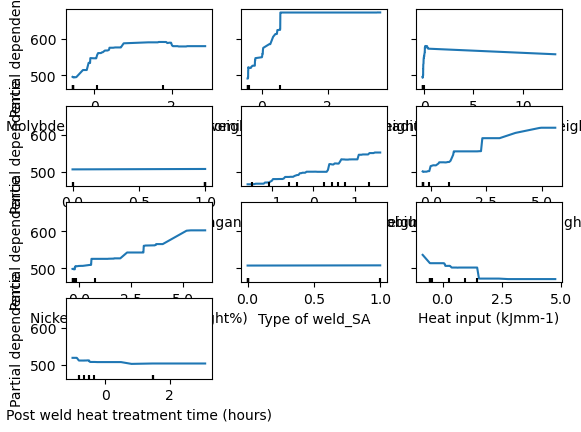

In [142]:
from sklearn.inspection import PartialDependenceDisplay

# Define the list of the most important features based on the chart


# Generate partial dependence plots for the most important features
PartialDependenceDisplay.from_estimator(best_model, X_train, top_10_features)
plt.show()


Partial dependence plots (PDPs) illustrate the average effect of each feature on the predicted outcome (yield strength) while keeping other features constant. This helps you understand how the yield strength changes as a specific feature value changes.

- Key Observations:

    - Molybdenum Concentration: As molybdenum concentration increases, the yield strength generally increases. This suggests a positive relationship, meaning higher molybdenum concentrations are beneficial for increasing yield strength.

    - Type of Weld (e.g., SA, TSA): Categorical features like the type of weld (represented as binary 0 or 1) show noticeable jumps, indicating significant influence on yield strength based on the weld type.

    - Heat Input (kJ/mm): Initially, yield strength decreases slightly as heat input increases, but stabilizes after a certain value. This suggests that lower heat inputs might be more favorable for higher yield strength.

    - Post Weld Heat Treatment Time: The yield strength tends to decrease with increasing heat treatment time, indicating that prolonged heat treatment could reduce the material's yield strength.

### Learning Curves

Generate learning curves to understand model performance:

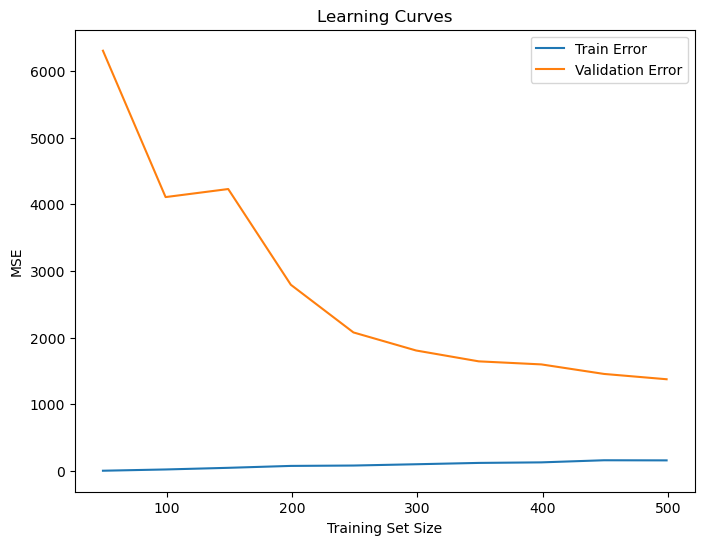

In [134]:
from sklearn.model_selection import learning_curve

# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', 
    train_sizes=np.linspace(0.1, 1.0, 10))

# Plot learning curves
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, -train_scores.mean(axis=1), label='Train Error')
plt.plot(train_sizes, -test_scores.mean(axis=1), label='Validation Error')
plt.xlabel('Training Set Size')
plt.ylabel('MSE')
plt.title('Learning Curves')
plt.legend()
plt.show()


The training error is near zero, showing that the model learns well from the training data.

The validation error is significantly higher, suggesting overfitting. Increasing regularization (lambda or alpha) or employing early stopping could help reduce overfitting.